### Decision tree regressor

The theory for building a decision tree for regression tasks. This algorithm can later be used to create a random forest model. The image below shows some basic terminology and a sketch of a decision tree.

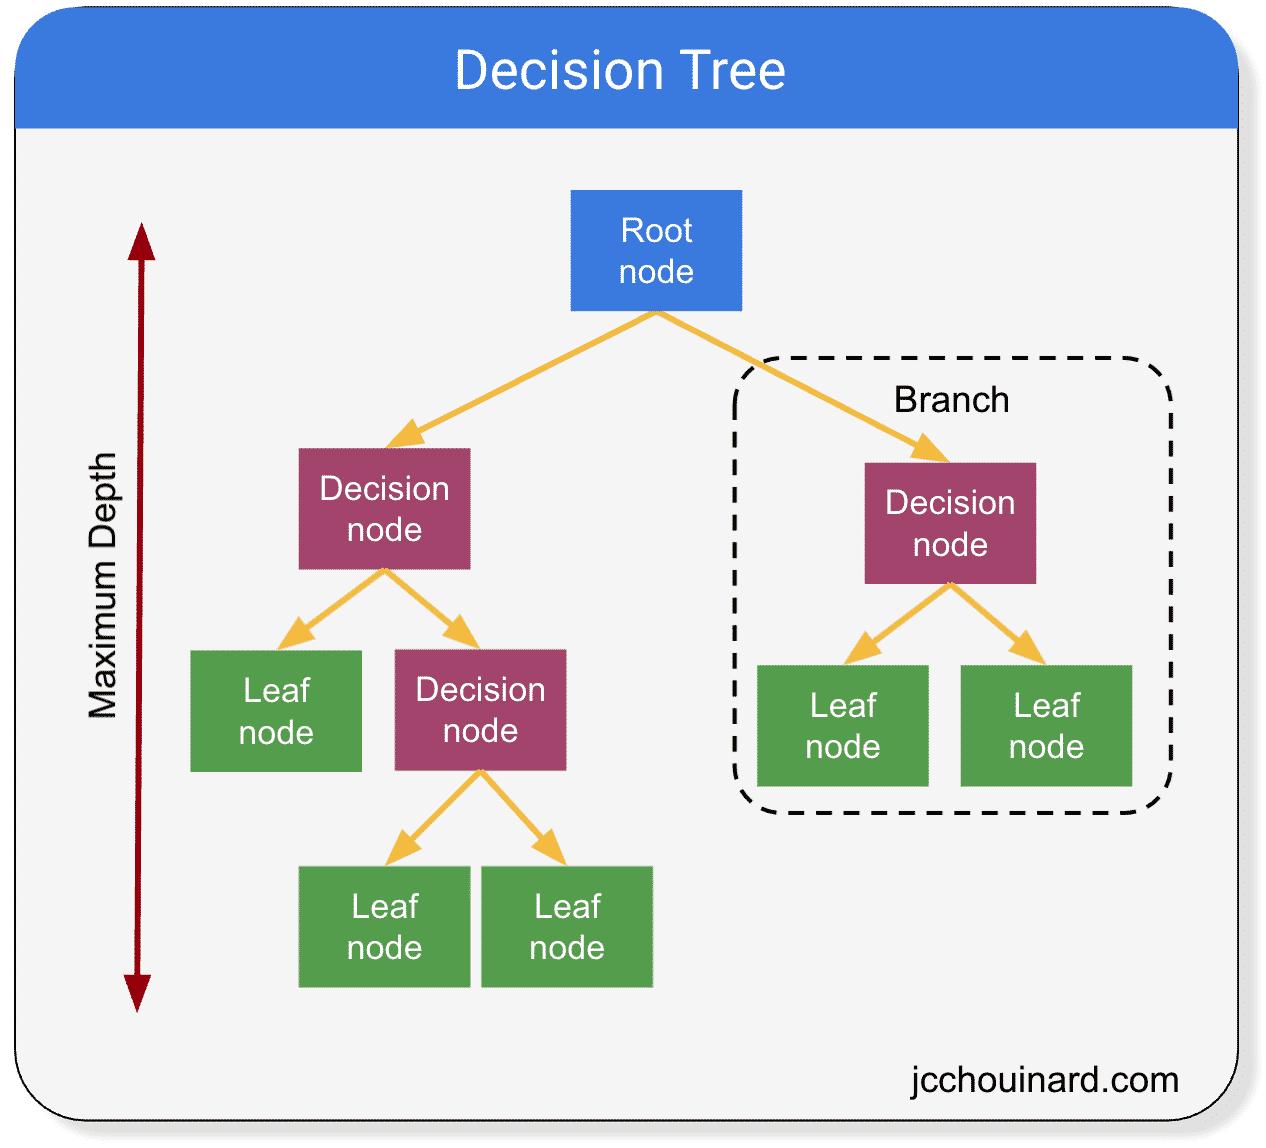

Image from: https://www.jcchouinard.com/decision-trees-in-machine-learning/

In [1]:
import numpy as np
import pandas as pd

For the following explanations I assume you already know how a decision tree classifier works, as explained in the other theory notebook.

The decision tree regressor works mostly the same as the classifier, but also requires some new code, as we now want to train on and predict continuous variables instead of boolean ones.
There are two main differences. The first is that we need a new splitting criterion, as the Gini impurity metric cannot be applied anymore, to determine which split improves the tree the most. The second is that we do not want to predict a label True/False at the end, but some value.

Let's start with the splitting criterion again. For regression, a 'pure' leaf would be one for which all values of the target variable lie close to each other. Since the tree will predict the mean of the target variable of samples in a leaf (from the training data), this way the prediction is less likely to be far off. If we have target samples that are very far apart in the same leaf, it would be very difficult for the tree to make an accurate prediction.

So to try and get samples together that have a similar target variable, we select splits that minimize the variance of all samples for the target variable. (Alternatively, the mean of the samples could be calculated as the current prediction of the leaf, with which we then calculate the mean squared error between it and all samples. This method achieves the same goal, but is a bit more computationally expensive.)

With this, the splitting works essentially the same as for the classification tree. To determine the combined variance after the split, we again take a weighted sum based on the number of entries per leaf:

\begin{equation}
    \mathrm{Var_{weighted}} = \frac{N_\mathrm{left}}{N_\mathrm{total}} \mathrm{Var_{left}} + \frac{N_\mathrm{right}}{N_\mathrm{total}} \mathrm{Var_{right}},
\end{equation}

where $N_\mathrm{total}$ is the number of entries before the split.

In [2]:
# Note that calculating variance is easily done using the numpy var function

def var_weighted(y_left, y_right):
    """
    Calculate the weighted variance after a split.
    
    Parameters:
    y_left (array-like): Array of labels for the left dataset.
    y_right (array-like): Array of labels for the right dataset.
    
    Returns:
    float: Weighted variance value.
    """
    N_left = len(y_left)
    N_right = len(y_right)
    N_total = N_left + N_right

    var_left = np.var(y_left) if N_left > 1 else 0.0
    var_right = np.var(y_right) if N_right > 1 else 0.0
    
    var_weighted = (N_left / N_total) * var_left + (N_right / N_total) * var_right
    return var_weighted

Next we look at how we create splits. This works the same as for the classification tree, except for the different metric.

In [ ]:
def determine_continuous_split(X_feature):
    """
    Determine the split points for a continuous feature, being the first quantile, median, and third quantile.
    If there are 3 or less unique values, this is not useful, so return the median instead.

    Parameters:
    X_feature (Series): Series of feature values.

    Returns:
    (list or float): List of split points [first quantile, median, third quantile], median if not enough data to determine quantiles.
    """
    if len(X_feature.unique()) <= 3:
        median = np.median(X_feature)
        return median  # Not enough data to determine quantiles
    else:
        first_quantile = np.quantile(X_feature, 0.25)
        median = np.median(X_feature)
        third_quantile = np.quantile(X_feature, 0.75)
        return [first_quantile, median, third_quantile]

def split_node_and_find_best_split(X_feature, y):
    """
    Split a node based on the feature values in X_feature while determining the best split point 
    based on variance for continuous features.
    
    Parameters:
    X_feature (Series): Series of feature values.
    y (Series): Series of target values.
    
    Returns:
    Series: Two Series representing the left and right splits for y.
    (float or None): The best split value for continuous features, None for boolean features.
    """
    # First figure out if the feature is continuous or boolean
    if set(X_feature.unique()).issubset({0, 1}):  # works for both 0/1 and True/False as values
        # Boolean feature
        #X_left = X_feature[X_feature == 0]
        #X_right = X_feature[X_feature == 1]
        y_left = y[X_feature.index[X_feature == 0]]
        y_right = y[X_feature.index[X_feature == 1]]
        best_split_value = None  # No split value for boolean features
    else:
        # Continuous feature
        split_points = determine_continuous_split(X_feature)

        # If split points are a single value (median), treat it as a binary split
        if isinstance(split_points, float):
            median = split_points
            #X_left = X_feature[X_feature <= median]
            #X_right = X_feature[X_feature > median]
            y_left = y[X_feature.index[X_feature <= median]]
            y_right = y[X_feature.index[X_feature > median]]
            best_split_value = median  # Need to return this
        else:
            # Figure out which split is best, using the lowest variance
            best_var = float('inf')
            for split_value in split_points:
                #X_left = X_feature[X_feature <= split_value]
                #X_right = X_feature[X_feature > split_value]
                y_left = y[X_feature.index[X_feature <= split_value]]
                y_right = y[X_feature.index[X_feature > split_value]]
                var = var_weighted(y_left, y_right)
                if var < best_var:
                    best_var = var
                    best_split_value = split_value
            # Now split based on the best split value found
            #X_left = X_feature[X_feature <= best_split_value]
            #X_right = X_feature[X_feature > best_split_value]
            y_left = y[X_feature.index[X_feature <= best_split_value]]
            y_right = y[X_feature.index[X_feature > best_split_value]]
    
    return y_left, y_right, best_split_value

# Then apply the function to each function and determine the best split
def determine_best_split(X, y):
    """
    Determine the best split for a dataset based on variance.
    
    Parameters:
    X (DataFrame): Feature dataframe.
    y (Series): Target values.
    
    Returns:
    tuple: The best feature and the best split value (None for boolean features).
    """
    best_var = float('inf')

    for column in X.columns:
        X_feature = X[column]
        y_left, y_right, best_split_value = split_node_and_find_best_split(X_feature, y)
        
        # Calculate variance for the split
        var = var_weighted(y_left, y_right)
        if var < best_var:
            best_var = var
            best_split_feature = (column, best_split_value)  # split_value is None for boolean features
    return best_split_feature

In [ ]:
# Test if it splits right
test_data = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8],
    'feature2': [0, 1, 0, 1, 0, 1, 0, 1],
    'target': [1.2, 1.1, 1.3, 1.1, 0.1, -0.1, 0.2, 0.0] # for feature1 better
    #'target': [1.2, 0.1, 1.1, -0.1, 1.3, 0.2, 1.1, 0.0] # for feature2 better
    })
X = test_data[['feature1', 'feature2']]
y = test_data['target']
best_split_feature = determine_best_split(X, y)
print("Best split feature:", best_split_feature)

Best split feature: ('feature1', 4.5)


pandas.core.series.Series

Now we add the function to determine whether the best split improved the purity above the set threshold, but with the variance metric.

In [ ]:
def check_var_decrease_threshold(y, y_left, y_right, threshold):
    """
    Calculate the variance decrease from a split and if it meets a threshold.
    
    Parameters:
    y (array-like): Array of target values before the split.
    y_left (array-like): Array of target values for the left dataset after the split.
    y_right (array-like): Array of target values for the right dataset after the split.
    threshold (float): The threshold to compare against.
    
    Returns:
    bool: True if the variance decrease is greater than the threshold, False otherwise.
    """
    var_before = np.var(y)
    var_after = var_weighted(y_left, y_right)
    
    return (var_before - var_after) > threshold

Finally we repeat the function that builds the tree. This is effectively the same as for classification, except for the metric again, and that we now take the prediction of a leaf to be the mean of the target values that end up in that leaf in the training data. (There are other options for this, like taking the median or some weighted mean, but for now we just implement the mean.) The `class` parameter in the tree dictionary is then also replaced for `value`.

In [ ]:
def split_node_given_best_split(X, y, feature, best_split_value):
    """
    Split a node based on the feature values in X_feature given the predetermined best split point.
    
    Parameters:
    X (DataFrame): Array of feature values.
    y (Series): Array of target values.
    best_split_value (float or None): The best split value for continuous features, None for boolean features.
    
    Returns:
    DataFrame: Two DataFrames representing the left and right splits for X.
    Series: Two Series representing the left and right splits for y.
    """
    X_feature = X[feature]
    if best_split_value is None:
        # Boolean feature
        X_left = X[X_feature == 0]
        X_right = X[X_feature == 1]
        y_left = y[X.index[X_feature == 0]]
        y_right = y[X.index[X_feature == 1]]
    else:
        X_left = X[X_feature <= best_split_value]
        X_right = X[X_feature > best_split_value]
        y_left = y[X.index[X_feature <= best_split_value]]
        y_right = y[X.index[X_feature > best_split_value]]
    
    return X_left, X_right, y_left, y_right

def build_tree(X, y, max_depth=None, min_samples_split=2, min_samples_leaf=1, verbose=False, threshold=0.0, depth=0):
    """
    Build up the tree recursively by fitting the training data.
    This needs to start with depth at 0, which is passed as an argument to make the recursion work.

    Parameters:
    X (DataFrame): Feature dataframe.
    y (Series): Target values.
    max_depth (int, optional): Maximum depth of the tree. Default is None (no limit).
    min_samples_split (int, optional): Minimum number of samples required to split an internal node. Default is 2.
    min_samples_leaf (int, optional): Minimum number of samples required to be at a leaf node. Default is 1.
    verbose (bool, optional): If True, print the reasons for stopping. Default is False.
    threshold (float): The threshold to compare against for increasing score, default=0.0.

    Returns:
    dict: A dictionary representing the decision tree.
    """
    # First check all stopping criteria
    if (max_depth is not None and depth >= max_depth):
        if verbose:
            print(f"Stopping at depth {depth} due to max_depth limit.")
        mean_value = y.mean()
        return {'value': mean_value, 'is_leaf': True}
    elif len(y) < min_samples_split:
        if verbose:
            print(f"Stopping at depth {depth} due to min_samples_split limit.")
        mean_value = y.mean()
        return {'value': mean_value, 'is_leaf': True}

    # For the variance score increase and min_samples_leaf criteria, we need to do the split first
    column, split_value = determine_best_split(X, y)
    X_left, X_right, y_left, y_right = split_node_given_best_split(X, y, column, split_value)
    if len(y_left) < min_samples_leaf or len(y_right) < min_samples_leaf:
        if verbose:
            print(f"Stopping at depth {depth} due to min_samples_leaf limit.")
        mean_value = y.mean()
        return {'value': mean_value, 'is_leaf': True}
    # Note that now the possibility exists that the best split resulted in too few samples in a leaf, 
    # but maybe another split would not do that, while still improving the variance score. 
    # Taking that into account by checking if another split does not result in too few samples in a leaf
    # is very computationally expensive though (you would basically have to run split_node_and_find_best_split() 
    # again while saving the order of the variance scores to find the second best, third best, etc. features), 
    # and the gain is likely very small, so we do not implement that here.
    
    better_score = check_var_decrease_threshold(y, y_left, y_right, threshold)
    if not better_score:
        if verbose:
            print(f"Stopping at depth {depth} as no better score is found.")
        mean_value = y.mean()
        return {'value': mean_value, 'is_leaf': True}
    
    # If none of the criteria are met, we continue here
    # If it is a boolean feature we can just take it out, as splitting on it again is nonsense
    if split_value is None:
        X_left = X_left.drop(columns=[column])
        X_right = X_right.drop(columns=[column])

    # Recursively build the left and right subtrees, adding 1 to the depth
    left_subtree = build_tree(X_left, y_left, max_depth=max_depth, min_samples_split=min_samples_split,
                              min_samples_leaf=min_samples_leaf, verbose=verbose, threshold=threshold,
                              depth=depth + 1)
    right_subtree = build_tree(X_right, y_right, max_depth=max_depth, min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf, verbose=verbose, threshold=threshold,
                               depth=depth + 1)

    # Return the current node with its left and right subtrees; in the end this contains the full tree
    return {
        'feature': column,
        'split': split_value,
        'is_leaf': False,
        'left': left_subtree,
        'right': right_subtree
    }

In [7]:
test_data = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8],
    'feature2': [0, 1, 0, 1, 0, 1, 0, 1],
    'feature3': [1, 1, 1, 0, 1, 0, 0, 0],
    'target': [0.1, 1.2, 1.5, 0.3, 1.4, 0.1, 1.1, 0.0]
    })
X = test_data[['feature1', 'feature2', 'feature3']]
y = test_data['target']
tree = build_tree(X, y, max_depth=3, min_samples_split=0, min_samples_leaf=0, verbose=True)
print("Decision Tree Structure:", tree)

Stopping at depth 2 as no better score is found.
Stopping at depth 3 due to max_depth limit.
Stopping at depth 3 due to max_depth limit.
Stopping at depth 2 as no better score is found.
Stopping at depth 3 due to max_depth limit.
Stopping at depth 3 due to max_depth limit.
Decision Tree Structure: {'feature': 'feature3', 'split': None, 'is_leaf': False, 'left': {'feature': 'feature2', 'split': None, 'is_leaf': False, 'left': {'value': 1.1, 'is_leaf': True}, 'right': {'feature': 'feature1', 'split': 6.0, 'is_leaf': False, 'left': {'value': 0.2, 'is_leaf': True}, 'right': {'value': 0.0, 'is_leaf': True}}}, 'right': {'feature': 'feature1', 'split': 1.75, 'is_leaf': False, 'left': {'value': 0.1, 'is_leaf': True}, 'right': {'feature': 'feature2', 'split': None, 'is_leaf': False, 'left': {'value': 1.45, 'is_leaf': True}, 'right': {'value': 1.2, 'is_leaf': True}}}}


Let's look at the resulting tree in detail:

```python
tree = {
    'feature': 'feature3', 
    'split': None, 
    'is_leaf': False, 
    'left': {
        'feature': 'feature2', 
        'split': None, 
        'is_leaf': False, 
        'left': {
            'value': 1.1, 
            'is_leaf': True
        }, 
        'right': {
            'feature': 'feature1', 
            'split': 6.0, 
            'is_leaf': False, 
            'left': {
                'value': 0.2, 
                'is_leaf': True
            }, 
            'right': {
                'value': 0.0, 
                'is_leaf': True
            }
        }
    }, 
    'right': {
        'feature': 'feature1', 
        'split': 1.75, 
        'is_leaf': False, 
        'left': {
            'value': 0.1, 
            'is_leaf': True
        }, 
        'right': {
            'feature': 'feature2', 
            'split': None, 
            'is_leaf': False, 
            'left': {
                'value': 1.45, 
                'is_leaf': True
            }, 
            'right': {
                'value': 1.2, 
                'is_leaf': True
            }
        }
    }
}
```

We can see that the `value` parameters are either around 0 or 1, as we would expect them to be.

Lastly the predict and score functions are added. Predicting works the same as for classification, but for the score we cannot use accuracy anymore. Instead, the root mean square error is returned, because that is generally what I'm most interested in.

In [8]:
def predict(tree, X):
    """
    Predict the value for each sample in X using the decision tree.
    
    Parameters:
    tree (dict): The decision tree structure.
    X (DataFrame): Feature dataframe for which to make predictions.
    
    Returns:
    array-like: Predicted value for each sample in X.
    """
    predictions = []
    
    for _, row in X.iterrows():
        node = tree  # start at the root node
        while not node['is_leaf']:
            feature = node['feature']
            split_value = node['split']
            data_feature_value = row[feature]
            if split_value is None:  # Boolean feature
                if data_feature_value == 0:
                    # As we trained the model to go left for 0, go left here
                    node = node['left']
                else:
                    node = node['right']
            else:  # Continuous feature
                if data_feature_value <= split_value:
                    # As we trained the model to go left for <= split_value, go left here
                    node = node['left']
                else:
                    node = node['right']
            # After going down, if the node is still not a leaf, repeat this
        # When we reach a leaf node, append the predicted value to the predictions
        predictions.append(node['value'])
    
    return np.array(predictions)

def score(y_true, y_pred):
    """
    Calculate the root mean square error of predictions.
    
    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.
    
    Returns:
    float: Root mean square error.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [9]:
test_predictions = predict(tree, X)
print("Predictions:", test_predictions)
print("True values:", y.values)
rmse = score(y, test_predictions)
print(f"Root Mean Square Error: {rmse:.4f}")

Predictions: [0.1  1.2  1.45 0.2  1.45 0.2  1.1  0.  ]
True values: [0.1 1.2 1.5 0.3 1.4 0.1 1.1 0. ]
Root Mean Square Error: 0.0559


That seems like a pretty good result. Now test on some larger datasets.

In [10]:
# Use the iris data again, but now with a regression target
iris_data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv', header=None)
iris_data.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Root Mean Square Error on Iris dataset: 0.3008


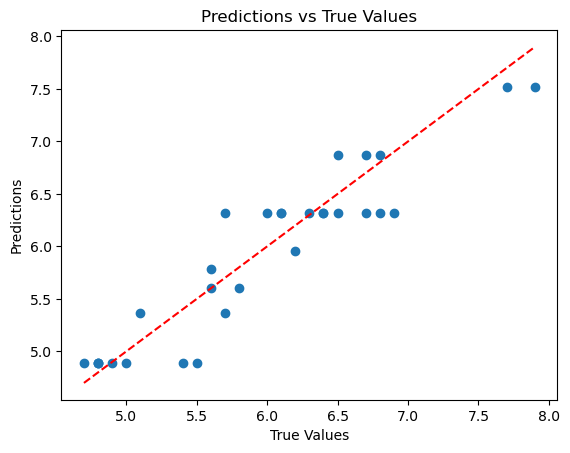

In [45]:
X = iris_data.drop(columns=[0])
y = iris_data[0]

# Map the labels to integers
label_mapping = {label: idx for idx, label in enumerate(X[4].unique())}
X[4] = X[4].map(label_mapping)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = build_tree(X_train, y_train, max_depth=3)
predictions = predict(tree, X_test)
rmse = score(y_test, predictions)
print(f"Root Mean Square Error on Iris dataset: {rmse:.4f}")

# Plot the predictions against the true values
import matplotlib.pyplot as plt
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # line for perfect predictions
plt.show()

In [12]:
# Compare with sklearn's DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
sklearn_tree = DecisionTreeRegressor(max_depth=3)
sklearn_tree.fit(X_train, y_train)
sklearn_predictions = sklearn_tree.predict(X_test)
sklearn_rmse = np.sqrt(mean_squared_error(y_test, sklearn_predictions))
print(f"Root Mean Square Error with sklearn's DecisionTreeRegressor: {sklearn_rmse:.4f}")

Root Mean Square Error with sklearn's DecisionTreeRegressor: 0.3330


We see that our implementation is actually slightly better here, while there is no observable difference in speed.

Root Mean Square Error on Diabetes dataset: 55.2773


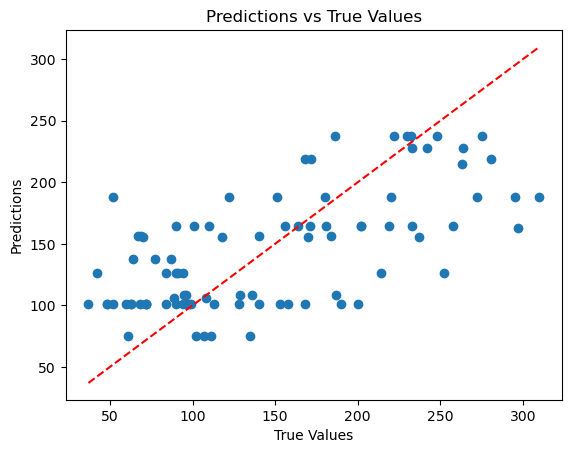

In [54]:
# Use the diabetes dataset as a regression example
from sklearn.datasets import load_diabetes
diabetes_data = load_diabetes()
X = pd.DataFrame(diabetes_data.data, columns=diabetes_data.feature_names)
y = pd.Series(diabetes_data.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = build_tree(X_train, y_train, max_depth=4)
predictions = predict(tree, X_test)
rmse = score(y_test, predictions)
print(f"Root Mean Square Error on Diabetes dataset: {rmse:.4f}")

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # line for perfect predictions
plt.show()

In [55]:
sklearn_tree = DecisionTreeRegressor(max_depth=4)
sklearn_tree.fit(X_train, y_train)
sklearn_predictions = sklearn_tree.predict(X_test)
sklearn_rmse = np.sqrt(mean_squared_error(y_test, sklearn_predictions))
print(f"Root Mean Square Error with sklearn's DecisionTreeRegressor on Diabetes dataset: {sklearn_rmse:.4f}")

Root Mean Square Error with sklearn's DecisionTreeRegressor on Diabetes dataset: 60.3614


The predictions we make on the diabetes data are quite bad, but those from sklearn are even worse, so I guess this model just does not work well on this data. Here we do see that it takes our tree about a second to run while sklearn is still instantaneous, so our implementation is slower.

Still, in the test cases it is clear that our implementation generates good results, comparable to sklearn. It is however fairly slow, just like the classifier, so that this might also not work well for larger datasets.